# Preprocess images and masks
* Generate masks from the original Kaggle annotations
* Convert the masks generated with clustering and SIFT/Gauss filtering into the same format as the original masks
* Slice images and masks into four parts for easier handling during U-net modeling

In [1]:
import os
import pathlib
import shutil

import pandas as pd
import numpy as np

import imageio
import matplotlib.pyplot as plt

In [2]:
# Get the directory of the repository
curr_dir = os.getcwd()
parent_dir = pathlib.Path(curr_dir).parents[1]
print(parent_dir)

/Users/philipp/neuefische/ds-capstone-img-classification-segmentation


In [3]:
# Load the original Kaggle metadata file
filename = f"{parent_dir}/data/data_original/train.csv"
df = pd.read_csv(filename)

HEIGHT = 520 #image height
WIDTH = 704 #image width
shape = (HEIGHT, WIDTH)

## Create single-channel and one-hot-encoded masks from the running length annotations
* `ID_mask.png` &rarr; single-channel masks
* `ID_mask_oh.png` &rarr; one-hot masks

In [4]:
unique_id = df.id.unique()


for i, my_id in enumerate(unique_id):
    df_subs = df[df.id==my_id]
    mask = np.zeros(np.prod(shape), dtype = np.uint8)

    for annotation in df_subs.annotation:
        annotation = annotation.split()
        list_1s = [(int(start)-1, int(start)-1 + int(length)) for start, length in zip(annotation[0:][::2], annotation[1:][::2])]
        for start, end in list_1s:
            mask[start:end] += 1

    mask[mask>1] = 1 # Do not treat overlap as separate class

    mask = mask.reshape(shape)
    
    # One class regardless of overlap (third channel is padding to still be able to save as RGB image)
    mask_oh = np.zeros((HEIGHT, WIDTH, 3), dtype = np.uint8)
    mask_oh[:,:,0] = (mask==0).astype(int)
    mask_oh[:,:,1] = (mask>0).astype(int)
    
    # # Separate class for overlapping annotations
    # mask_oh = np.zeros((HEIGHT, WIDTH, 3), dtype = np.uint8)
    # mask_oh[:,:,0] = (mask==0).astype(int)
    # mask_oh[:,:,1] = (mask==1).astype(int)
    # mask_oh[:,:,2] = (mask==2).astype(int)

    mask_folder = '~/neuefische/ds-capstone-img-classification-segmentation/data/data_preprocessed/mask_groundtruth/'

    mask_path    = mask_folder + my_id + '_mask.png'
    mask_oh_path = mask_folder + my_id + '_mask_oh.png'

    imageio.imwrite(mask_path, mask)
    imageio.imwrite(mask_oh_path, mask_oh)
    
    if (i+1)%100==0:
        print(f"{i+1} images processed")

100 images processed
200 images processed
300 images processed
400 images processed
500 images processed
600 images processed


## Copy the results to new folders where the astro masks are going to be replaced with the clustering masks

Further down in this notebook, masks based on the clustering algorithm (see notebooks `Jonas's notebook` and `Torben's notebook`) are generated for astro images only. Here, we copy the original masks in these folders as the modeling pipeline picks a folder that needs to contain all masks (original for cort and shsy5y, clustering for astro) rather than selecting the desired mask type across folders for each cell type individually

#### Nomenclature:
* cg = masks based on clustering + Gauss filter
* cs = masks based on clustering + SIFT

In [6]:
dir_data   = f"{parent_dir}/data/data_preprocessed/"
dir_source = f"{dir_data}/mask_groundtruth/"

# clustered-SIFT -> masks_cs
dir_target = dir_data +  "mask_cluster/masks_cs/"
shutil.copytree(dir_source, dir_target, dirs_exist_ok=True)


# clustered-Gauss -> masks_cg
dir_target = dir_data +  "mask_cluster/masks_cg/"
shutil.copytree(dir_source, dir_target, dirs_exist_ok=True)

'/Users/philipp/neuefische/ds-capstone-img-classification-segmentation/data/data_preprocessed/mask_cluster/masks_cg/'

## Convert and store the masks generated with clustering for cell type "astro"

In [7]:
# For loading the clustered masks
dir_cluster = f"{dir_data}/mask_cluster/"

# For storing the selected and preprocessed clustered masks -> folder dictionary -> {cg source: target, cs source: target}
folders = {"segmented_img/": "masks_cg/", "segmented_img_sift/": "masks_cs/"}

# To select astro masks only
df.drop_duplicates(subset = "id", inplace = True)
mask_ids = df.loc[df["cell_type"]=="astro","id"].tolist()

In [8]:
# Loop over cg and cs
for source, target in folders.items():
    
    # Loop over mask IDs
    for mask_id in mask_ids:
        
        mask = imageio.imread(f"{dir_cluster}before_preprocessing/{source}{mask_id}_seg.png")
        
        # Transform pixel values from [0, 255] to [0, 1]
        mask = (mask==255).astype(np.uint8)
        
        # One-hot masks with two channels (third channel is padding to still be able to save as RGB image)
        mask_oh = np.zeros((mask.shape[0], mask.shape[1], 3))
        mask_oh[:,:,0] = (mask==0).astype(int)
        mask_oh[:,:,1] = (mask>0).astype(int)
        
        # # Create one-hot encoded mask - keep three channels despite n classes = 2 to ensure compatibility
        # # with the masks created from the original annotations
        # mask_oh = np.zeros((mask.shape[0], mask.shape[1], 3))
        # mask_oh[:,:,0] = (mask==0)
        # mask_oh[:,:,1] = (mask==1)
        # mask_oh[:,:,2] = (mask==2)
        
        # Store the masks
        imageio.imwrite(f"{dir_cluster}{target}{mask_id}_mask.png", mask.astype(np.uint8))
        imageio.imwrite(f"{dir_cluster}{target}{mask_id}_mask_oh.png", mask_oh.astype(np.uint8))

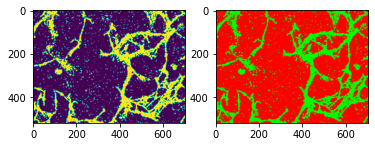

In [9]:
# Plot single image mask to check everything went okay
fig, ax = plt.subplots(1,2)
ax[0].imshow(mask)
ax[1].imshow(mask_oh)

## Slice images and masks in four quadrants
Our U-net implementations take 128 x 128 pixels input images and masks to preserve RAM. To not lose too much of the original images' resolution, we split the images into four parts before feeding them into our models.

### Define the slicing function

In [11]:
def img_slicer(dir_source, dir_target):
    
    fname_orig = [f for f in os.listdir(dir_source) if f.endswith('.png')]
    
    for fname in fname_orig:
        img = imageio.imread(dir_source + fname)
        
        upper = range(0, int(HEIGHT/2))
        lower = range(int(HEIGHT/2), HEIGHT)
        
        left  = range(0, int(WIDTH/2))
        right = range(int(WIDTH/2), WIDTH)
        
        img_a = img[upper,:][:,left]
        img_b = img[upper,:][:,right]
        img_c = img[lower,:][:,left]
        img_d = img[lower,:][:,right]
        
        fname_no_ext = fname.split(".")[0]
        
        if "mask_oh" in fname_no_ext:
            fname_no_ext = fname_no_ext.split("_")
            imageio.imwrite(dir_target + fname_no_ext[0] + "_a_mask_oh.png", img_a)
            imageio.imwrite(dir_target + fname_no_ext[0] + "_b_mask_oh.png", img_b)
            imageio.imwrite(dir_target + fname_no_ext[0] + "_c_mask_oh.png", img_c)
            imageio.imwrite(dir_target + fname_no_ext[0] + "_d_mask_oh.png", img_d)
        elif "mask" in fname_no_ext:
            fname_no_ext = fname_no_ext.split("_")
            imageio.imwrite(dir_target + fname_no_ext[0] + "_a_mask.png", img_a)
            imageio.imwrite(dir_target + fname_no_ext[0] + "_b_mask.png", img_b)
            imageio.imwrite(dir_target + fname_no_ext[0] + "_c_mask.png", img_c)
            imageio.imwrite(dir_target + fname_no_ext[0] + "_d_mask.png", img_d)
        else:
            imageio.imwrite(dir_target + fname_no_ext + "_a.png", img_a)
            imageio.imwrite(dir_target + fname_no_ext + "_b.png", img_b)
            imageio.imwrite(dir_target + fname_no_ext + "_c.png", img_c)
            imageio.imwrite(dir_target + fname_no_ext + "_d.png", img_d)

### Process the original images

In [12]:
# Run the image slicer on the original masks
dir_data   = f"{parent_dir}/data/data_preprocessed/"
dir_source = f"{dir_data}mask_groundtruth/"
dir_target = f"{dir_data}sliced_images/masks/"

img_slicer(dir_source, dir_target)

### Process the masks from clustering + SIFT/Gauss filtering

In [15]:
# Run the image slicer on the cs masks

dir_source = f"{dir_data}mask_cluster/masks_cs/"
dir_target = f"{dir_data}sliced_images/masks_cs/"

img_slicer(dir_source, dir_target)

In [16]:
# Run the image slicer on the cg masks

dir_source = f"{dir_data}mask_cluster/masks_cg/"
dir_target = f"{dir_data}sliced_images/masks_cg/"

img_slicer(dir_source, dir_target)